In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

### Generate synthetic spike data

In [2]:
# Create a simple single-spike signal
def generate_signal(l, spike_width, spike_std, n_spikes=1, a=1.0, b=0.0, plot=False):
    if n_spikes > 0:
        spikes = [signal.gaussian(spike_width, std=spike_std) for _ in range(n_spikes)]
        baseline = min(spikes[0])
    # Otherwise just generate one Gaussian w/ same params to get min value matching
    else:
        baseline = min(signal.gaussian(spike_width, std=spike_std))
    
    # Assemble the signal piecewise
    w = l - n_spikes * spike_width
    assert w > 0
    segments = []
    for i in range(n_spikes):
        w_split = np.random.randint(w)
        segments.append([baseline] * w_split)
        segments.append(spikes[i])
        w -= w_split
    segments.append([baseline] * w)
    
    # Return the signal, optionally plotting as well
    X = np.hstack(segments)
    X = a*X + b
    if plot:
        plt.plot(X)
        plt.show()
    return X

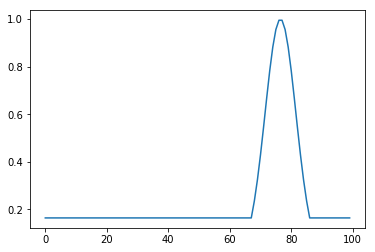

In [3]:
_ = generate_signal(100, 20, 5, n_spikes=1, plot=True)

In [4]:
def generate_dataset_1(n=1000, signal_len=100, spike_width=20, spike_std=5):
    Y = np.random.randint(1, 3, n) # Note: labels in {1,2}
    X = np.array(
        [generate_signal(signal_len, spike_width, spike_std, n_spikes=y-1) for y in Y]
    ).reshape(n, signal_len, 1)
    return X, Y

X, Y = generate_dataset_1()
X_test, Y_test = generate_dataset_1()

In [5]:
X.shape

(1000, 100, 1)

### Test LSTM

In [6]:
from metal.modules import LSTMModule
from metal.end_model import EndModel

def test_lstm(X, Y, X_test, Y_test, X_dev=None, Y_dev=None, lstm_reduction="max", n_epochs=15, lr=0.1):
    k = 2
    embed_size = 1
    hidden_size = 10

    lstm_module = LSTMModule(
        embed_size,
        hidden_size,
        skip_embeddings=True,
        bidirectional=False,
        verbose=True,
        lstm_reduction=lstm_reduction,
    )

    em = EndModel(
        k=k,
        input_module=lstm_module,
        layer_out_dims=[hidden_size, k],
        optimizer="adam",
        batchnorm=True,
        seed=1,
        verbose=True,
    )
    
    dev_data = (X_dev, Y_dev) if X_dev is not None and Y_dev is not None else None
    em.train_model((X, Y), dev_data=dev_data, n_epochs=n_epochs, lr=lr)
    score = em.score((X_test, Y_test), verbose=True)

In [7]:
test_lstm(X, Y, X_test, Y_test)

Skipping embeddings and using direct input.

Network architecture:
Sequential(
  (0): Sequential(
    (0): LSTMModule(
      (lstm): LSTM(1, 10, batch_first=True)
    )
    (1): ReLU()
  )
  (1): Linear(in_features=10, out_features=2, bias=True)
)




[E:0]	Train Loss: 0.504



[E:1]	Train Loss: 0.057



[E:2]	Train Loss: 0.018



[E:3]	Train Loss: 0.011



[E:4]	Train Loss: 0.008



[E:5]	Train Loss: 0.006



[E:6]	Train Loss: 0.005



[E:7]	Train Loss: 0.004



[E:8]	Train Loss: 0.003



[E:9]	Train Loss: 0.003



[E:10]	Train Loss: 0.002



[E:11]	Train Loss: 0.002



[E:12]	Train Loss: 0.002



[E:13]	Train Loss: 0.002



[E:14]	Train Loss: 0.001
Finished Training
Accuracy: 1.000
        y=1    y=2   
 l=1    486     0    
 l=2     0     514   


### Counting test

In [8]:
def generate_dataset_2(n=1000, signal_len=100, spike_width=20, spike_std=5):
    Y = np.random.randint(1, 3, n) # Note: labels in {1,2}
    X = np.array(
        [generate_signal(signal_len, spike_width, spike_std, n_spikes=y) for y in Y]
    ).reshape(n, signal_len, 1)
    return X, Y

X, Y = generate_dataset_2()
X_test, Y_test = generate_dataset_2()

In [9]:
test_lstm(X, Y, X_test, Y_test, lstm_reduction="attention")

Skipping embeddings and using direct input.

Network architecture:
Sequential(
  (0): Sequential(
    (0): LSTMModule(
      (lstm): LSTM(1, 10, batch_first=True)
    )
    (1): ReLU()
  )
  (1): Linear(in_features=10, out_features=2, bias=True)
)




[E:0]	Train Loss: 0.669



[E:1]	Train Loss: 0.664



[E:2]	Train Loss: 0.418



[E:3]	Train Loss: 0.109



[E:4]	Train Loss: 0.038



[E:5]	Train Loss: 0.022



[E:6]	Train Loss: 0.015



[E:7]	Train Loss: 0.009



[E:8]	Train Loss: 0.009



[E:9]	Train Loss: 0.006



[E:10]	Train Loss: 0.005



[E:11]	Train Loss: 0.004



[E:12]	Train Loss: 0.003



[E:13]	Train Loss: 0.003



[E:14]	Train Loss: 0.002
Finished Training
Accuracy: 1.000
        y=1    y=2   
 l=1    485     0    
 l=2     0     515   


### Normalization test

In [10]:
def generate_dataset_3(n=1000, signal_len=100, spike_width=20, spike_std=5):
    Y = np.random.randint(1, 3, n) # Note: labels in {1,2}
    X = np.array([
        generate_signal(
            signal_len,
            spike_width, spike_std,
            n_spikes=y-1,
            a=np.random.rand(),
            b=np.random.rand()
    ) for y in Y]).reshape(n, signal_len, 1)
    return X, Y

X, Y = generate_dataset_3()
X_dev, Y_dev = generate_dataset_3()
X_test, Y_test = generate_dataset_3()

test_lstm(X, Y, X_test, Y_test, X_dev=X_dev, Y_dev=Y_dev, lstm_reduction="attention", lr=0.01, n_epochs=25)

Skipping embeddings and using direct input.

Network architecture:
Sequential(
  (0): Sequential(
    (0): LSTMModule(
      (lstm): LSTM(1, 10, batch_first=True)
    )
    (1): ReLU()
  )
  (1): Linear(in_features=10, out_features=2, bias=True)
)




Saving model at iteration 0 with best score 0.512
[E:0]	Train Loss: 0.694	Dev accuracy: 0.512



[E:1]	Train Loss: 0.693	Dev accuracy: 0.512



Saving model at iteration 2 with best score 0.596
[E:2]	Train Loss: 0.691	Dev accuracy: 0.596



Saving model at iteration 3 with best score 0.600
[E:3]	Train Loss: 0.692	Dev accuracy: 0.600



Saving model at iteration 4 with best score 0.696
[E:4]	Train Loss: 0.645	Dev accuracy: 0.696



Saving model at iteration 5 with best score 0.816
[E:5]	Train Loss: 0.517	Dev accuracy: 0.816



Saving model at iteration 6 with best score 0.826
[E:6]	Train Loss: 0.412	Dev accuracy: 0.826



Saving model at iteration 7 with best score 0.829
[E:7]	Train Loss: 0.395	Dev accuracy: 0.829



Saving model at iteration 8 with best score 0.876
[E:8]	Train Loss: 0.358	Dev accuracy: 0.876



[E:9]	Train Loss: 0.318	Dev accuracy: 0.785



[E:10]	Train Loss: 0.347	Dev accuracy: 0.862



Saving model at iteration 11 with best score 0.877
[E:11]	Train Loss: 0.273	Dev accuracy: 0.877



Saving model at iteration 12 with best score 0.890
[E:12]	Train Loss: 0.202	Dev accuracy: 0.890



[E:13]	Train Loss: 0.263	Dev accuracy: 0.864



Saving model at iteration 14 with best score 0.928
[E:14]	Train Loss: 0.226	Dev accuracy: 0.928



Saving model at iteration 15 with best score 0.951
[E:15]	Train Loss: 0.145	Dev accuracy: 0.951



[E:16]	Train Loss: 0.151	Dev accuracy: 0.922



[E:17]	Train Loss: 0.328	Dev accuracy: 0.823



[E:18]	Train Loss: 0.329	Dev accuracy: 0.866



[E:19]	Train Loss: 0.288	Dev accuracy: 0.874



[E:20]	Train Loss: 0.257	Dev accuracy: 0.904



[E:21]	Train Loss: 0.233	Dev accuracy: 0.903



[E:22]	Train Loss: 0.218	Dev accuracy: 0.933



[E:23]	Train Loss: 0.181	Dev accuracy: 0.949



[E:24]	Train Loss: 0.174	Dev accuracy: 0.939
Restoring best model from iteration 15 with score 0.951
Finished Training
Accuracy: 0.951
        y=1    y=2   
 l=1    512    49    
 l=2     0     439   
Accuracy: 0.947
        y=1    y=2   
 l=1    495    53    
 l=2     0     452   


### Sequential test
Small-then-big versus big-then-small...

In [29]:
def generate_dataset_4(n=1000, signal_len=100, spike_width=10, spike_std=5):
    Y = np.random.randint(1, 3, n) # Note: labels in {1,2}
    X = np.array([
        np.vstack([
            generate_signal(int(0.5*signal_len), y * spike_width, spike_std, n_spikes=1),
            generate_signal(int(0.5*signal_len), (1 + 2*(y%2)) * spike_width, spike_std, n_spikes=1)
        ])
        for y in Y
    ]).reshape(n, signal_len, 1)
    return X, Y

X, Y = generate_dataset_4()
X_test, Y_test = generate_dataset_4()

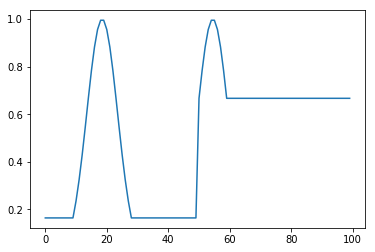

In [30]:
plt.plot(X[1])

In [31]:
test_lstm(X, Y, X_test, Y_test, n_epochs=10)

Skipping embeddings and using direct input.

Network architecture:
Sequential(
  (0): Sequential(
    (0): LSTMModule(
      (lstm): LSTM(1, 10, batch_first=True)
    )
    (1): ReLU()
  )
  (1): Linear(in_features=10, out_features=2, bias=True)
)




[E:0]	Train Loss: 0.700



[E:1]	Train Loss: 0.444



[E:2]	Train Loss: 0.003



[E:3]	Train Loss: 0.000



[E:4]	Train Loss: 0.000



[E:5]	Train Loss: 0.000



[E:6]	Train Loss: 0.000



[E:7]	Train Loss: 0.000



[E:8]	Train Loss: 0.000



[E:9]	Train Loss: 0.000
Finished Training
Accuracy: 1.000
        y=1    y=2   
 l=1    500     0    
 l=2     0     500   


### Variable sequence length
Pad with zeros...

In [44]:
def generate_dataset_5(n=1000, max_signal_len=100, spike_width=20, spike_std=5):
    Y = np.random.randint(1, 3, n) # Note: labels in {1,2}
    X = []
    for y in Y:
        signal_len = 2*spike_width + int(np.random.random() * (max_signal_len - 2*spike_width))
        x = np.pad(
            generate_signal(signal_len, spike_width, spike_std, n_spikes=y-1),
            [0, max_signal_len - signal_len],
            'constant'
        )
        X.append(x)
    X = np.array(X).reshape(n, max_signal_len, 1)
    return X, Y

X, Y = generate_dataset_5()
X_test, Y_test = generate_dataset_5()

In [52]:
test_lstm(X, Y, X_test, Y_test, n_epochs=10)

Skipping embeddings and using direct input.

Network architecture:
Sequential(
  (0): Sequential(
    (0): LSTMModule(
      (lstm): LSTM(1, 10, batch_first=True)
    )
    (1): ReLU()
  )
  (1): Linear(in_features=10, out_features=2, bias=True)
)




[E:0]	Train Loss: 0.678



[E:1]	Train Loss: 0.700



[E:2]	Train Loss: 0.314



[E:3]	Train Loss: 0.043



[E:4]	Train Loss: 0.021



[E:5]	Train Loss: 0.015



[E:6]	Train Loss: 0.011



[E:7]	Train Loss: 0.009



[E:8]	Train Loss: 0.007



[E:9]	Train Loss: 0.006
Finished Training
Accuracy: 1.000
        y=1    y=2   
 l=1    501     0    
 l=2     0     499   


### Very Long Sequence length

In [53]:
X, Y = generate_dataset_1(signal_len=10000)
X_test, Y_test = generate_dataset_1(signal_len=10000)

In [54]:
test_lstm(X, Y, X_test, Y_test, n_epochs=5)

Skipping embeddings and using direct input.

Network architecture:
Sequential(
  (0): Sequential(
    (0): LSTMModule(
      (lstm): LSTM(1, 10, batch_first=True)
    )
    (1): ReLU()
  )
  (1): Linear(in_features=10, out_features=2, bias=True)
)




[E:0]	Train Loss: 0.339



[E:1]	Train Loss: 0.011



[E:2]	Train Loss: 0.001



[E:3]	Train Loss: 0.000



[E:4]	Train Loss: 0.000
Finished Training
Accuracy: 1.000
        y=1    y=2   
 l=1    523     0    
 l=2     0     477   
